# SVM and Logistic Regression Modeling

**Created by Phillip Efthimion, Scott Payne, Gino Varghese and John Blevins**

*MSDS 7331 Data Mining - Section 403 - Mini Project*

In this notebook a publicly available data set which is related to the popularities of online news sites will be analyzed. The online news popularity data set utilized in this analysis is publicly accessible from the UCI machine learning repository at https://archive.ics.uci.edu/ml/datasets/Online+News+Popularity.  The dataset can provide interesting insights into the popularity of online news articles based on article metadata such as word patterns, media content, message sentiment, day of publication and more. In this analysis, the ability to predict popularity is examined based on these attributes. As part of the analysis two different classification models will be considered: Logistic Regression and Support Vector Machines.  Of particular interest is a comparison between these two classification techniques and interpretation of the results.  The effectiveness of what makes either a good prediction algorithm will be based primarily on the performance accuracy and the input parameters of each will be varied to observe the affect on the output.   

Python data tools will be used to tidy the data, fit the models and perform further exploratory analysis.  The following Python modules are required:
* Pandas
* Numpy
* Matplotlib
* Seaborn
* Sklearn
* Plotly
* Statsmodels.api
* Warnings
* Datetime

The shares attribute in the dataset represents the popularity value to be estimated.  This attribute is a continuous numeric type in the data set and must be recoded as a categorized response variable before performing the analysis.  This is done by establishing threshold for "popular" versus "non-popular" and generating a new result variable where share values are grouped as such.  The data will also be filtered based on articles having to do with technology.  This is due to the size of the original dataset and the amount of processing required to fit models for the dataset in it's entirety.  The population of interest is therefore limited to a these types of articles and any statistical results of the analysis limited as such.  In addition, attributes which don't provide useful explanetory functions in the anaylsys will be removed from the dataset.  An 80/20 training/testing split will be utilized for the model fitting and each model will be assessed for accuracy and performance.  Given the relatively small number of features in the data set a linear kernel specification will be used to fit each model.

In [79]:
# Import and Configure Required Modules
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import warnings
import datetime
warnings.simplefilter('ignore', DeprecationWarning)
plt.rcParams['figure.figsize']=(15,10)

# Read Online News Data
df = pd.read_csv('data/OnlineNewsPopularity.csv')

# Correct Column Names by Removing Leading Space
df.columns = df.columns.str.replace(' ', '')

# Rename Columns for Ease of Display
df = df.rename(columns={'weekday_is_monday': 'monday', 'weekday_is_tuesday': 'tuesday', 'weekday_is_wednesday': 'wednesday', 'weekday_is_thursday': 'thursday', 'weekday_is_friday': 'friday', 'weekday_is_saturday': 'saturday', 'weekday_is_sunday': 'sunday', 'is_weekend': 'weekend'})
df = df.rename(columns={'data_channel_is_lifestyle':'lifestyle', 'data_channel_is_entertainment':'entertainment', 'data_channel_is_bus':'business', 'data_channel_is_socmed':'social_media', 'data_channel_is_tech':'technology', 'data_channel_is_world':'world'})

# Encode a new "popular" column based on the # of shares 
# "popular" = 1 and "not popular" to 0.
df['popularity'] = pd.qcut(df['shares'].values, 2, labels=[0,1])
df.popularity = df.popularity.astype(np.int)

# Take a subset of the data related to Technology News Articles
dfsubset = df.loc[df['technology'] == 1]

# Reassign to New Variable and remove Columns which aren't needed
df_imputed = dfsubset
del df_imputed['url']
del df_imputed['shares']
del df_imputed['timedelta']
del df_imputed['lifestyle']
del df_imputed['entertainment']
del df_imputed['business']
del df_imputed['social_media']
del df_imputed['technology']
del df_imputed['world']

# Display Dataframe Structure
df_imputed.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 7346 entries, 4 to 39639
Data columns (total 53 columns):
n_tokens_title                  7346 non-null float64
n_tokens_content                7346 non-null float64
n_unique_tokens                 7346 non-null float64
n_non_stop_words                7346 non-null float64
n_non_stop_unique_tokens        7346 non-null float64
num_hrefs                       7346 non-null float64
num_self_hrefs                  7346 non-null float64
num_imgs                        7346 non-null float64
num_videos                      7346 non-null float64
average_token_length            7346 non-null float64
num_keywords                    7346 non-null float64
kw_min_min                      7346 non-null float64
kw_max_min                      7346 non-null float64
kw_avg_min                      7346 non-null float64
kw_min_max                      7346 non-null float64
kw_max_max                      7346 non-null float64
kw_avg_max                  

___
## Training and Testing Split
The binary popularity value will be predicted, where 0 represents non-popular articles while 1 represents popular articles. The remaining attributes will be included in the development of the prediction models.  An instance of the ShuffleSplit object is created from sklearn to setup the cross validation parameters.  The data will be split such that 80% of the data is put into a training dataset and the remaining 20% in a test dataset.

In [80]:
from sklearn.model_selection import ShuffleSplit

# we want to predict the X and y data as follows:
if 'popularity' in df_imputed:
    y = df_imputed['popularity'].values # get the labels we want
    del df_imputed['popularity'] # get rid of the class label
    X = df_imputed.values # use everything else to predict!

    ## X and y are now numpy matrices, by calling 'values' on the pandas data frames we
    #    have converted them into simple matrices to use with scikit learn
    
    
# to use the cross validation object in scikit learn, we need to grab an instance
#    of the object and set it up. This object will be able to split our data into 
#    training and testing splits, 3 iterations 
#    80% in training dataset and 20% for test
num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2)
                         
print(cv_object)

ShuffleSplit(n_splits=3, random_state=None, test_size=0.2, train_size=None)


## Logistic Regression
A logistic regression model will be fit on the three iterations of the cross validation object (cv_object).  During each iteration the resultant accuracy, confusion matrix and training time will be calculated.

In [81]:
# run logistic regression and vary some parameters
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt

# first we create a reusable logisitic regression object
#   here we can setup the object with different learning parameters and constants
lr_clf = LogisticRegression(penalty='l2', C=1.0, class_weight=None) # get object

# now we can use the cv_object that we setup before to iterate through the 
#    different training and testing sets. Each time we will reuse the logisitic regression 
#    object, but it gets trained on different data each time we use it.

iter_num=0
# the indices are the rows used for training and testing in each iteration
for train_indices, test_indices in cv_object.split(X,y): 
    # I will create new variables here so that it is more obvious what 
    # the code is doing (you can compact this syntax and avoid duplicating memory,
    # but it makes this code less readable)
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    # train the reusable logisitc regression model on the training data
    train_start_time = datetime.datetime.now()
    lr_clf.fit(X_train,y_train)  # train object
    train_end_time = datetime.datetime.now()
    train_time = train_end_time - train_start_time
        
    y_hat = lr_clf.predict(X_test) # get test set precitions

    # now let's get the accuracy and confusion matrix for this iterations of training/testing
    acc = mt.accuracy_score(y_test,y_hat)
    conf = mt.confusion_matrix(y_test,y_hat)
    print("====Iteration",iter_num," ====")
    print("accuracy", acc )
    print("Confusion matrix\n",conf)
    print("Training time", train_time)
    iter_num+=1
    
    
# Also note that every time you run the above code
#   it randomly creates a new training and testing set, 
#   so accuracy will be different each time

====Iteration 0  ====
accuracy 0.606802721088
Confusion matrix
 [[115 496]
 [ 82 777]]
Training time 0:00:00.202145
====Iteration 1  ====
accuracy 0.61768707483
Confusion matrix
 [[130 467]
 [ 95 778]]
Training time 0:00:00.227141
====Iteration 2  ====
accuracy 0.612244897959
Confusion matrix
 [[113 501]
 [ 69 787]]
Training time 0:00:00.191137


### Parameter Adjustment for Improving Accuracy
Attributes that don't provide any explanatory value have already been removed that would have affected the fitted model.  In addition the cost can be adjusted to improve accuracy.  The cost parameter tells the model optimization how much training data you want to avoid being misclassified. The large the cost, the optimization will choose smaller-margin hyperplane, the hyperplane does a good job in getting all the points in the training data classified. Similarly a small cost value will let the optimization to look for larger-margin separating hyperplane,in this approach the hyperplane ignore some points the training data will still be linearly separable.

In [82]:
# here we can change some of the parameters interactively
from ipywidgets import widgets as wd

def lr_explor(cost):
    lr_clf = LogisticRegression(penalty='l2', C=cost, class_weight=None) # get object
    accuracies = cross_val_score(lr_clf,X,y=y,cv=cv_object) # this also can help with parallelism
    print(accuracies)

wd.interact(lr_explor,cost=(0.001,5.0,0.05),__manual=True)

<function __main__.lr_explor>

### Interpretting weights for Logistic Regression

SCOTT

In [83]:
# interpret the weights

# iterate over the coefficients
weights = lr_clf.coef_.T # take transpose to make a column vector
variable_names = df_imputed.columns
for coef, name in zip(weights,variable_names):
    print(name, 'has weight of', coef[0])
    
# does this look correct? 

n_tokens_title has weight of -0.000146898377062
n_tokens_content has weight of 0.000436990274584
n_unique_tokens has weight of -8.53607277434e-06
n_non_stop_words has weight of -1.16074948733e-05
n_non_stop_unique_tokens has weight of -9.2095220185e-06
num_hrefs has weight of 0.000145112455223
num_self_hrefs has weight of -0.000178860258295
num_imgs has weight of -0.000141750165941
num_videos has weight of 1.94254915917e-05
average_token_length has weight of -5.14591887244e-05
num_keywords has weight of -8.95315556997e-05
kw_min_min has weight of -0.000729493300613
kw_max_min has weight of 3.10805692459e-05
kw_avg_min has weight of -0.000253577430035
kw_min_max has weight of -1.37549699503e-06
kw_max_max has weight of -1.5353707215e-06
kw_avg_max has weight of 2.62526020524e-07
kw_min_avg has weight of 3.71338940954e-05
kw_max_avg has weight of -5.08991809246e-05
kw_avg_avg has weight of 0.000557795391011
self_reference_min_shares has weight of 1.66061609649e-06
self_reference_max_shar

SCOTT

** These weight interpretations **are not neccessarily interpretable** because of the values we had. Very large attribute values could just as easily be assigned a higher weight. Instead, let's normalize the feature values so that all the attributes are on the same dynamic range. Once we normalize the attributes, the weights should have magnitudes that reflect their poredictive power in the logistic regression model.
___

In [84]:
from sklearn.preprocessing import StandardScaler

# we want to normalize the features based upon the mean and standard deviation of each column. 
# However, we do not want to accidentally use the testing data to find out the mean and std (this would be snooping)
# to Make things easier, let's start by just using whatever was last stored in the variables:
##    X_train , y_train , X_test, y_test (they were set in a for loop above)

# scale attributes by the training set
scl_obj = StandardScaler()
scl_obj.fit(X_train) # find scalings for each column that make this zero mean and unit std
# the line of code above only looks at training data to get mean and std and we can use it 
# to transform new feature data

X_train_scaled = scl_obj.transform(X_train) # apply to training
X_test_scaled = scl_obj.transform(X_test) # apply those means and std to the test set (without snooping at the test set values)

# train the model just as before
lr_clf = LogisticRegression(penalty='l2', C=0.05) # get object, the 'C' value is less (can you guess why??)
lr_clf.fit(X_train_scaled,y_train)  # train object

y_hat = lr_clf.predict(X_test_scaled) # get test set precitions

acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
print('accuracy:', acc )
print(conf )

# sort these attributes and spit them out
zip_vars = zip(lr_clf.coef_.T,df_imputed.columns) # combine attributes
zip_vars = sorted(zip_vars)
for coef, name in zip_vars:
    print(name, 'has weight of', coef[0]) # now print them out

accuracy: 0.648299319728
[[237 377]
 [140 716]]
kw_max_avg has weight of -0.227627172213
global_rate_positive_words has weight of -0.189919484927
num_self_hrefs has weight of -0.159556162261
n_unique_tokens has weight of -0.133171419333
avg_negative_polarity has weight of -0.0994727938744
rate_negative_words has weight of -0.0984594107378
avg_positive_polarity has weight of -0.0904906024891
kw_max_min has weight of -0.0882256657983
kw_max_max has weight of -0.0837704678265
self_reference_avg_sharess has weight of -0.0740948552523
tuesday has weight of -0.0603900920331
num_keywords has weight of -0.0603651685112
LDA_01 has weight of -0.0586734303312
wednesday has weight of -0.0574124042055
global_sentiment_polarity has weight of -0.0528712236308
thursday has weight of -0.0464874929764
n_non_stop_words has weight of -0.0452622313545
kw_min_max has weight of -0.0445982338948
num_imgs has weight of -0.0395584584732
kw_min_avg has weight of -0.0374547168662
n_tokens_title has weight of -0.0

SCOTT

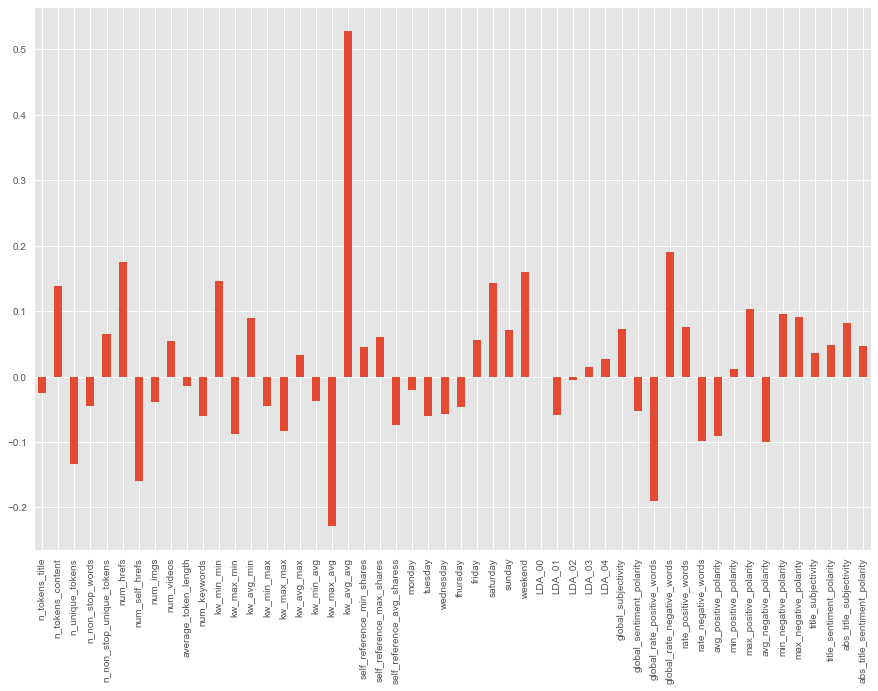

In [85]:
# now let's make a pandas Series with the names and values, and plot them
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize']=(15,10)

weights = pd.Series(lr_clf.coef_[0],index=df_imputed.columns)
weights.plot(kind='bar')
plt.show()

SCOTT

**For more improvement and guarding against overfitting:** At this point it would make sense to remove variables that are highly related to one another or ones that are irrelevant and keep going with the weights analysis. What variables would you remove?
___

In [86]:
from sklearn.preprocessing import StandardScaler
# we want to normalize the features based upon the mean and standard deviation of each column. 
# However, we do not want to accidentally use the testing data to find out the mean and std (this would be snooping)

from sklearn.pipeline import Pipeline
# you can apply the StandardScaler function inside of the cross-validation loop 
#  but this requires the use of PipeLines in scikit. 
#  A pipeline can apply feature pre-processing and data fitting in one compact notation
#  Here is an example!

std_scl = StandardScaler()
lr_clf = LogisticRegression(penalty='l2', C=0.05) 

# create the pipline
piped_object = Pipeline([('scale', std_scl),  # do this
                         ('logit_model', lr_clf)]) # and then do this

weights = []
# run the pipline cross validated
for iter_num, (train_indices, test_indices) in enumerate(cv_object.split(X,y)):
    piped_object.fit(X[train_indices],y[train_indices])  # train object
    # it is a little odd getting trained objects from a  pipeline:
    weights.append(piped_object.named_steps['logit_model'].coef_[0])
    

weights = np.array(weights)

SCOTT

In [87]:
import plotly
plotly.offline.init_notebook_mode() # run at the start of every notebook

error_y=dict(
            type='data',
            array=np.std(weights,axis=0),
            visible=True
        )

graph1 = {'x': df_imputed.columns,
          'y': np.mean(weights,axis=0),
    'error_y':error_y,
       'type': 'bar'}

fig = dict()
fig['data'] = [graph1]
fig['layout'] = {'title': 'Logistic Regression Weights, with error bars'}

plotly.offline.iplot(fig)

SCOTT

**For more improvement and guarding against overfitting:** At this point it would make sense to remove variables that are highly related to one another or ones that are irrelevant and keep going with the weights analysis. What variables would you remove?

From Gino - If we use a 0.1 threshold from the weight plot, we see that n_tokens_content, n_unique_tokens, n_non_stop_unique_tokens, num_hrefs, num_self_hrefs, kw_min_min, kw_max_max, kw_max_avg, kw_avg_avg, self_reference_avg_sharess, saturday, weekend, global_rate_positive_words, global_rate_negative_words and rate_negative_words all have the most weight in predicting popularity.

In [88]:
Xnew = df_imputed[['n_tokens_content', 'n_unique_tokens', 'n_non_stop_unique_tokens', 'num_hrefs', 'num_self_hrefs', 'kw_min_min', 'kw_max_max', 'kw_max_avg', 'kw_avg_avg', 'self_reference_avg_sharess', 'saturday', 'weekend', 'global_rate_positive_words', 'global_rate_negative_words', 'rate_negative_words']].values

weights = []
# run the pipline corssvalidated
for iter_num, (train_indices, test_indices) in enumerate(cv_object.split(Xnew,y)):
    piped_object.fit(Xnew[train_indices],y[train_indices])  # train object
    weights.append(piped_object.named_steps['logit_model'].coef_[0])
    
weights = np.array(weights)

error_y=dict(
            type='data',
            array=np.std(weights,axis=0),
            visible=True
        )

graph1 = {'x': ['n_tokens_content', 'n_unique_tokens', 'n_non_stop_unique_tokens', 'num_hrefs', 'num_self_hrefs', 'kw_min_min', 'kw_max_max', 'kw_max_avg', 'kw_avg_avg', 'self_reference_avg_sharess', 'saturday', 'weekend', 'global_rate_positive_words', 'global_rate_negative_words', 'rate_negative_words'],
          'y': np.mean(weights,axis=0),
    'error_y':error_y,
       'type': 'bar'}

fig = dict()
fig['data'] = [graph1]
fig['layout'] = {'title': 'Logistic Regression Weights, with error bars'}

plotly.offline.iplot(fig)




Scott

From Gino - If we use a 0.1 threshold from the weight plot, we see that n_tokens_content, n_unique_tokens, n_non_stop_unique_tokens, num_hrefs, num_self_hrefs, kw_min_min, kw_max_max, kw_max_avg, kw_avg_avg,  weekend, global_rate_positive_words, global_rate_negative_words and rate_negative_words all have the most weight in predicting popularity.


From Gino - Deleted self_reference_avg_share and saturday 

In [89]:
Xnew = df_imputed[['n_tokens_content', 'n_unique_tokens', 'n_non_stop_unique_tokens', 'num_hrefs', 'num_self_hrefs', 'kw_min_min', 'kw_max_max', 'kw_max_avg', 'kw_avg_avg', 'weekend', 'global_rate_positive_words', 'global_rate_negative_words', 'rate_negative_words']].values

weights = []
# run the pipline corssvalidated
for iter_num, (train_indices, test_indices) in enumerate(cv_object.split(Xnew,y)):
    piped_object.fit(Xnew[train_indices],y[train_indices])  # train object
    weights.append(piped_object.named_steps['logit_model'].coef_[0])
    
weights = np.array(weights)

error_y=dict(
            type='data',
            array=np.std(weights,axis=0),
            visible=True
        )

graph1 = {'x': ['n_tokens_content', 'n_unique_tokens', 'n_non_stop_unique_tokens', 'num_hrefs', 'num_self_hrefs', 'kw_min_min', 'kw_max_max', 'kw_max_avg', 'kw_avg_avg', 'weekend', 'global_rate_positive_words', 'global_rate_negative_words', 'rate_negative_words'],
          'y': np.mean(weights,axis=0),
    'error_y':error_y,
       'type': 'bar'}

fig = dict()
fig['data'] = [graph1]
fig['layout'] = {'title': 'Logistic Regression Weights, with error bars'}

plotly.offline.iplot(fig)

Scott 

From Gino - If we use a 0.1 threshold from the weight plot, we see that n_tokens_content, n_unique_tokens, n_non_stop_unique_tokens, num_hrefs, num_self_hrefs, kw_min_min, kw_max_avg, kw_avg_avg,  weekend, global_rate_positive_words, global_rate_negative_words and rate_negative_words all have the most weight in predicting popularity.


From Gino - Deleted kw_max_max

In [90]:
Xnew = df_imputed[['n_tokens_content', 'n_unique_tokens', 'n_non_stop_unique_tokens', 'num_hrefs', 'num_self_hrefs', 'kw_min_min', 'kw_max_avg', 'kw_avg_avg', 'weekend', 'global_rate_positive_words', 'global_rate_negative_words', 'rate_negative_words']].values

weights = []
# run the pipline corssvalidated
for iter_num, (train_indices, test_indices) in enumerate(cv_object.split(Xnew,y)):
    piped_object.fit(Xnew[train_indices],y[train_indices])  # train object
    weights.append(piped_object.named_steps['logit_model'].coef_[0])
    
weights = np.array(weights)

error_y=dict(
            type='data',
            array=np.std(weights,axis=0),
            visible=True
        )

graph1 = {'x': ['n_tokens_content', 'n_unique_tokens', 'n_non_stop_unique_tokens', 'num_hrefs', 'num_self_hrefs', 'kw_min_min', 'kw_max_avg', 'kw_avg_avg', 'weekend', 'global_rate_positive_words', 'global_rate_negative_words', 'rate_negative_words'],
          'y': np.mean(weights,axis=0),
    'error_y':error_y,
       'type': 'bar'}

fig = dict()
fig['data'] = [graph1]
fig['layout'] = {'title': 'Logistic Regression Weights, with error bars'}

plotly.offline.iplot(fig)

## Support Vector Machines
A support vector machine model will be fit on the three iterations of the cross validation object (cv_object).  During each iteration the resultant accuracy, confusion matrix and training time will be calculated.  

### Parameter Adjustment for Improved Accuracy
Either Linear or RBF kernel could have been used for this analysis however the linear kernel tends to perform better with a larger number of features.  RBF would be more appropriate for other applications like image classification.

In [91]:
from sklearn.svm import SVC

iter_num=0
# okay, so run through the cross validation loop and set the training and testing variable for one single iteration
for train_indices, test_indices in cv_object.split(X,y): 
    # I will create new variables here so that it is more obvious what 
    # the code is doing (you can compact this syntax and avoid duplicating memory,
    # but it makes this code less readable)
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    X_train_scaled = scl_obj.transform(X_train) # apply to training
    X_test_scaled = scl_obj.transform(X_test)
    
    # train the model just as before
    svm_clf = SVC(C=1, kernel='linear', degree=3, gamma='auto') # get object
    #svm_clf = SVC(C=0.5, kernel='rbf', degree=3, gamma='auto') # get object
    train_start_time = datetime.datetime.now()
    svm_clf.fit(X_train_scaled, y_train)  # train object
    train_end_time = datetime.datetime.now()
    
    train_time = train_end_time - train_start_time
    
    y_hat = svm_clf.predict(X_test_scaled) # get test set precitions

    acc = mt.accuracy_score(y_test,y_hat)
    conf = mt.confusion_matrix(y_test,y_hat)

    print("====Iteration",iter_num," ====")
    print('Accuracy:', acc )
    print('Training time:', train_time)
    print('Confusion Matrix:', conf)
       
    iter_num+=1


====Iteration 0  ====
Accuracy: 0.639455782313
Training time: 0:00:06.224265
Confusion Matrix: [[162 420]
 [110 778]]
====Iteration 1  ====
Accuracy: 0.632653061224
Training time: 0:00:06.293773
Confusion Matrix: [[174 412]
 [128 756]]
====Iteration 2  ====
Accuracy: 0.614965986395
Training time: 0:00:05.865557
Confusion Matrix: [[163 436]
 [130 741]]


PHILLIP

The dimensions of the array of support vectors, the dimensions of the indices and the number of support vectors for each class can be displayed.

In [92]:
# look at the support vectors
print(svm_clf.support_vectors_.shape)
print(svm_clf.support_.shape)
print(svm_clf.n_support_ )

(4637, 52)
(4637,)
[2309 2328]


PHILLIP


[[-0.02730786  0.11046712 -0.44543339 -0.05952941  0.28433528  0.07902873
  -0.07378863 -0.02979148  0.11830157  0.04327074 -0.04183401  0.1521704
   0.06287212 -0.00429671 -0.03656343 -0.14876582  0.05390821 -0.13578944
  -0.50522613  0.82105942  0.02038932  0.00675692  0.02614316  0.01738535
  -0.01978196 -0.10246688 -0.06623767  0.08920971  0.08908421  0.06031071
   0.11034692  0.01547583 -0.06454054 -0.00092563 -0.03379988  0.03957432
   0.04450832 -0.05320514 -0.25161269  0.22320843  0.09659451 -0.12651742
  -0.06033612  0.01918344  0.08865811 -0.13299158  0.11005103  0.06800207
  -0.00348028  0.05463631  0.0439365   0.06242006]]


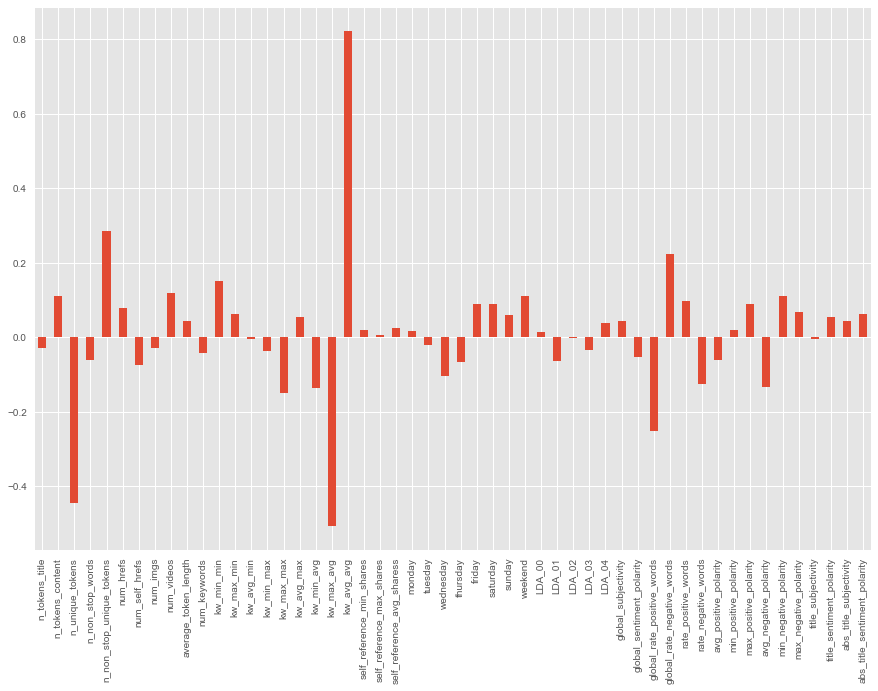

In [93]:
# if using linear kernel, these make sense to look at (not otherwise, why?)
print(svm_clf.coef_)
weights = pd.Series(svm_clf.coef_[0],index=df_imputed.columns)
weights.plot(kind='bar')

PHILLIP

Need help with df_imputed['popularity'] = y # also add it back in for the original data Returns some weird error 

In [99]:
# Now let's do some different analysis with the SVM and look at the instances that were chosen as support vectors

# now lets look at the support for the vectors and see if we they are indicative of anything
# grabe the rows that were selected as support vectors (these are usually instances that are hard to classify)

# make a dataframe of the training data
df_tested_on = df_imputed.loc[train_indices] # saved from above, the indices chosen for training
# now get the support vectors from the trained model
df_support = df_tested_on.loc[svm_clf.support_,:]
df_support['popularity'] = y[svm_clf.support_] # add back in the 'Survived' Column to the pandas dataframe
#print(df_imputed['popularity'])

#df_imputed.info()
# df_imputed['popularity'] = y # also add it back in for the original data
#df_support.info()

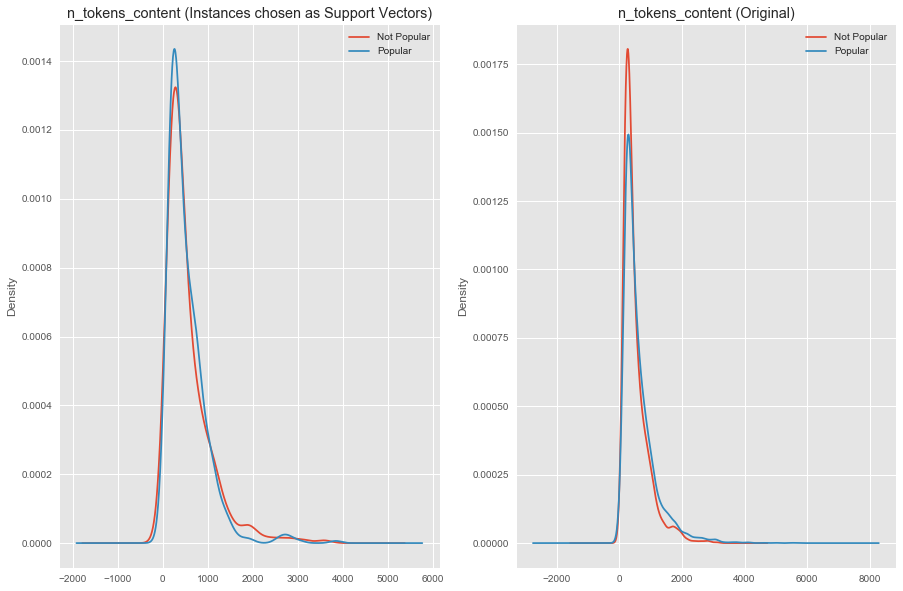

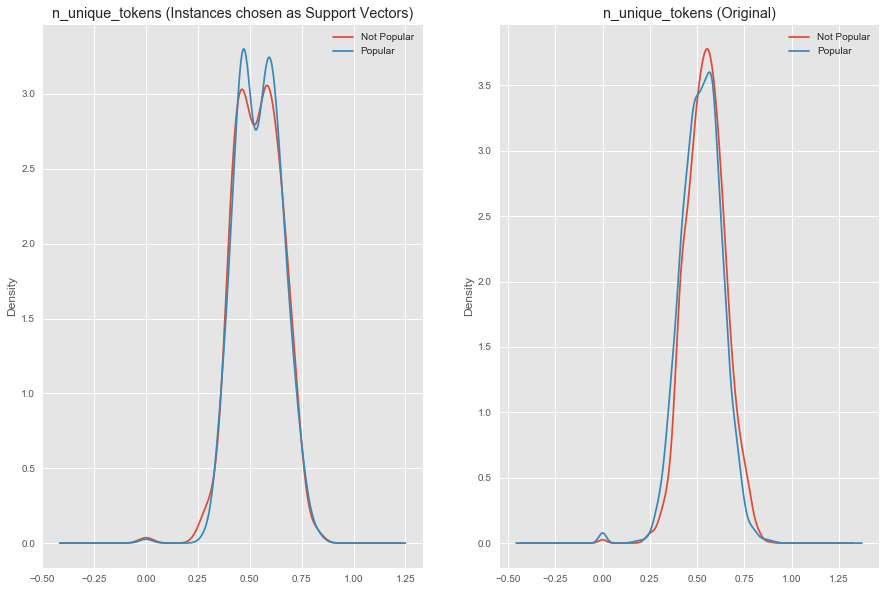

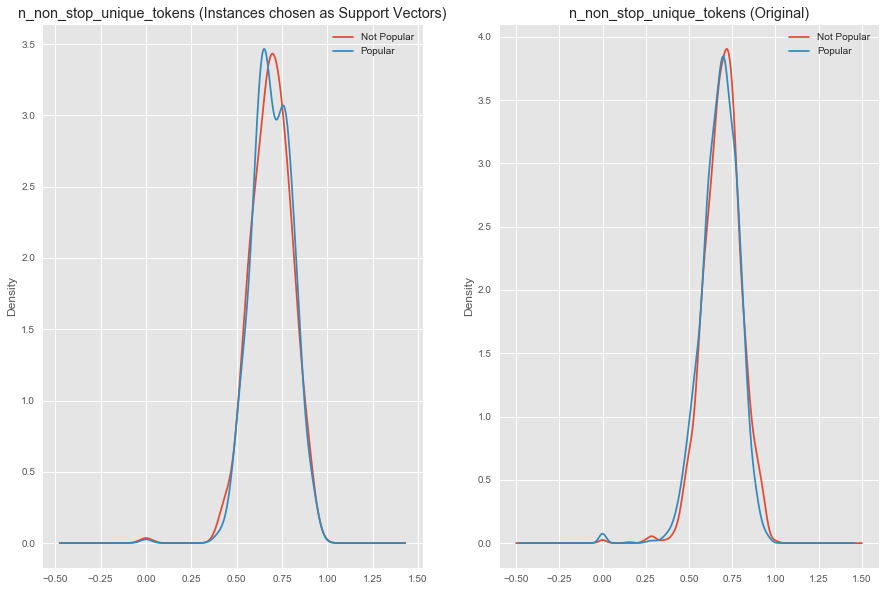

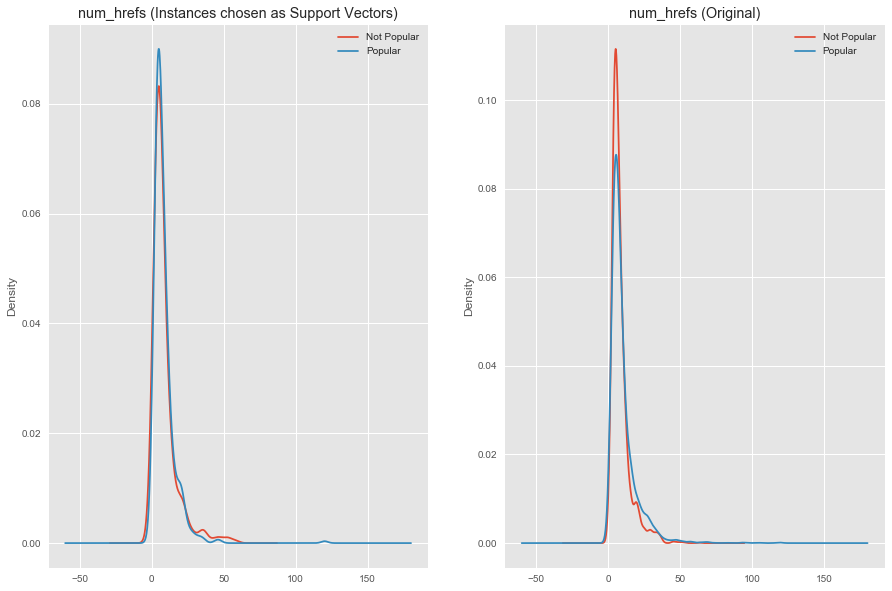

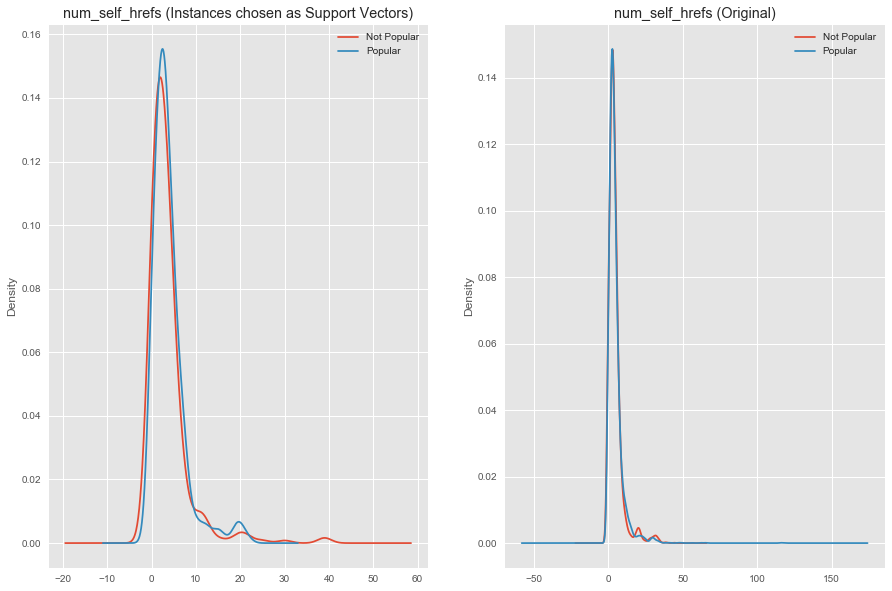

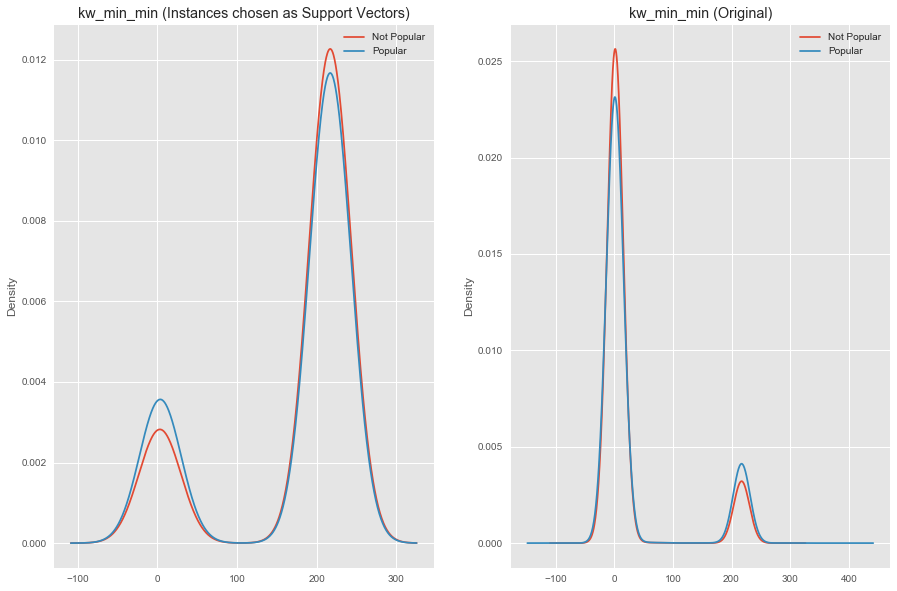

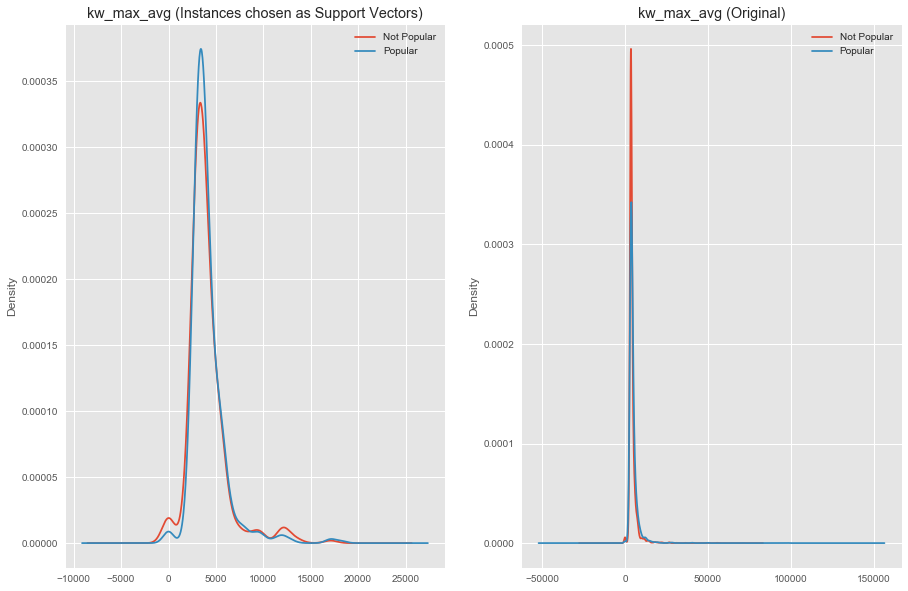

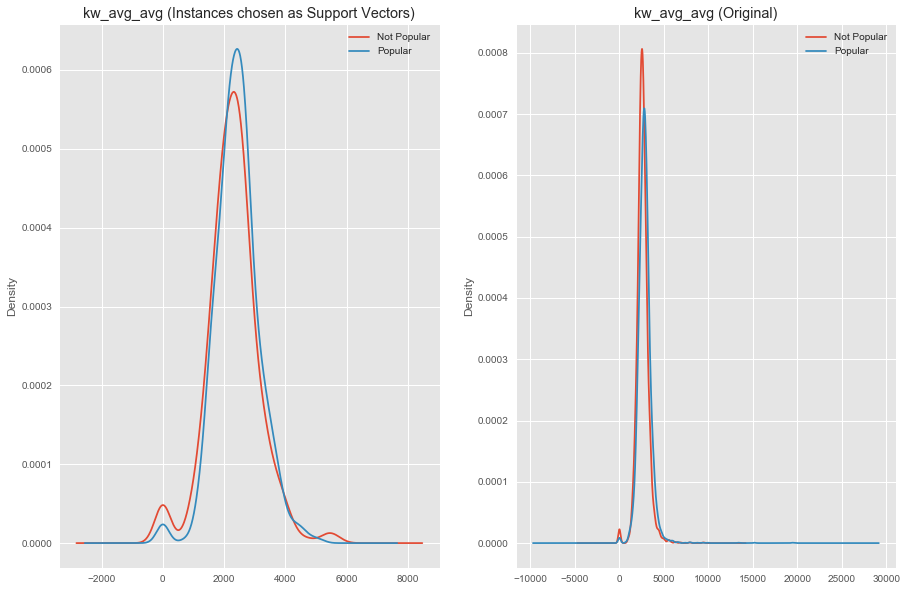

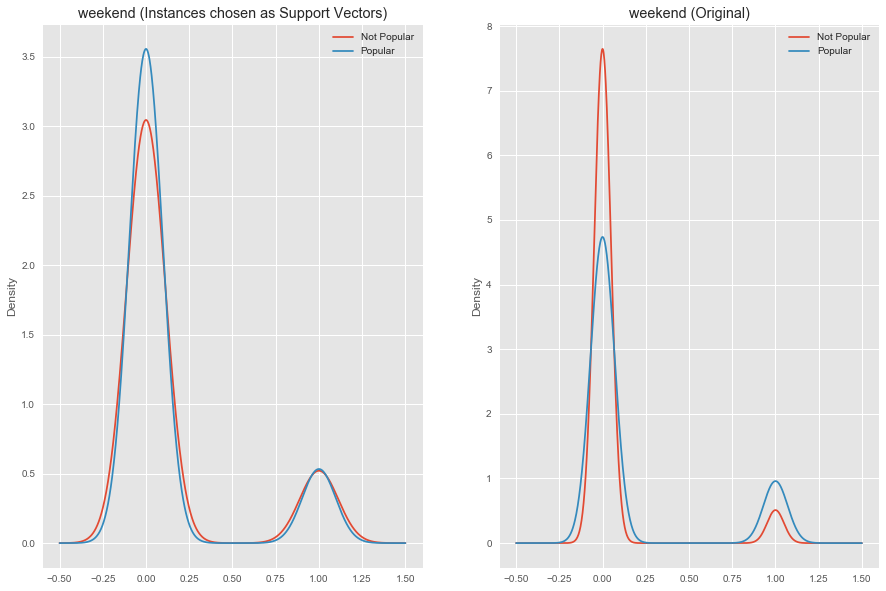

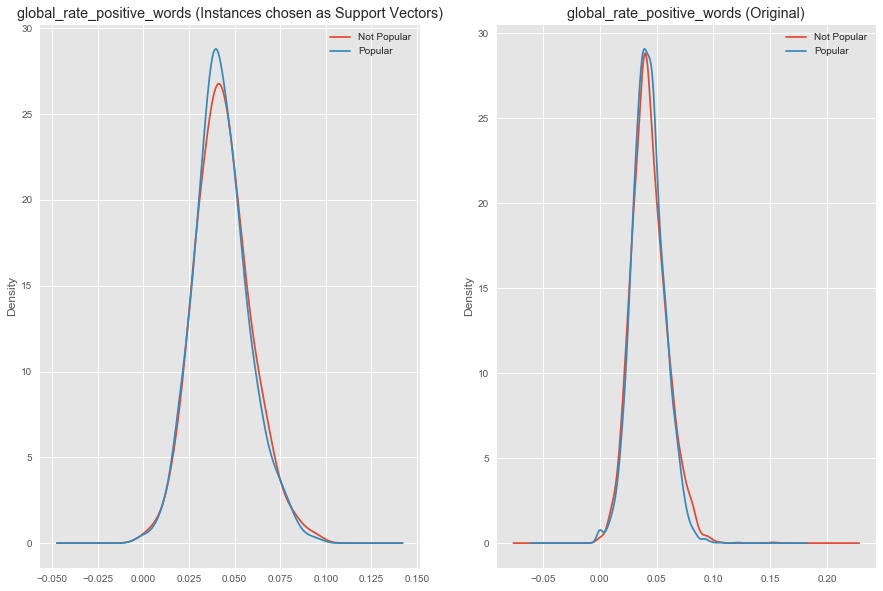

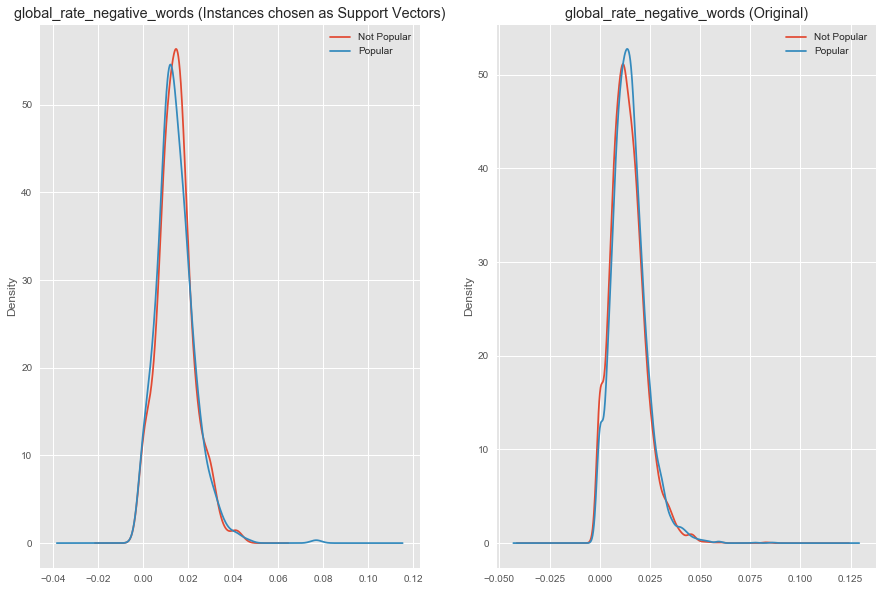

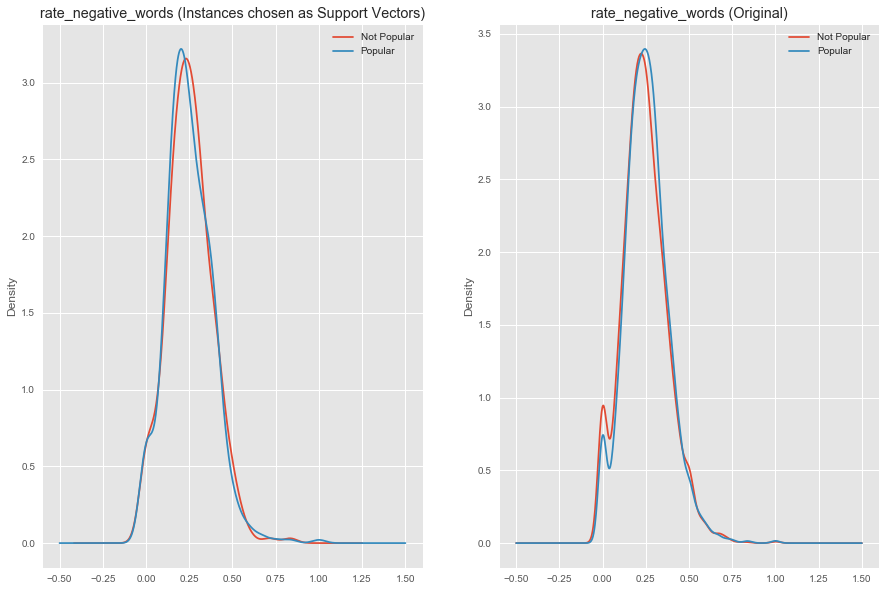

In [100]:
# now lets see the statistics of these attributes
from pandas.tools.plotting import boxplot

# group the original data and the support vectors
df_grouped_support = df_support.groupby(['popularity'])
df_grouped = df_imputed.groupby(['popularity'])

# plot KDE of Different variables
vars_to_plot = ['n_tokens_content', 'n_unique_tokens', 'n_non_stop_unique_tokens', 'num_hrefs', 'num_self_hrefs', 'kw_min_min', 'kw_max_avg', 'kw_avg_avg', 'weekend', 'global_rate_positive_words', 'global_rate_negative_words', 'rate_negative_words']

for v in vars_to_plot:
    plt.figure(figsize=(15,10))
    #plt.figure(figsize=(10,4))
    # plot support vector stats
    plt.subplot(1,2,1)
    ax = df_grouped_support[v].plot.kde() 
    plt.legend(['Not Popular','Popular'])
    plt.title(v+' (Instances chosen as Support Vectors)')
    
    # plot original distributions
    plt.subplot(1,2,2)
    ax = df_grouped[v].plot.kde() 
    plt.legend(['Not Popular','Popular'])
    plt.title(v+' (Original)')



PHILLIP

So the analysis here is basically telling us what the original statistics of the data looked like, and also what the statistics of the support vectors looked like. We can see that the separation in distributions is not as great as the separation for the original data. This is because the support vectors tend to be instances on the edge of the class boundaries and also instances that are classified incorrectly in the training data. 

You can also look at joint plots of the data and see how relationships have changed. (**Hint hint for the min-lab assignment**--this would be a nice analysis of the support vectors.)

That's mostly it for using these things! They are really nice analysis tools and provide human interpretable summaries of the data. 
___




## Advantages/Disadvantages of Each Model
The support vector model offers slightly better performance accuracy than the logistric regression model.  On average the accuracy is around 1% better for SVM.  This is expected due to ...  In terms of training time the support vector model does take significantly longer to complete.  On average it takes around 34 times longer to train the SVM model.    This is expected due to ...

## Sources
https://www.quora.com/Machine-Learning/How-does-one-decide-on-which-kernel-to-choose-for-an-SVM-RBF-vs-linear-vs-poly-kernel
http://www.csie.ntu.edu.tw/~cjlin/papers/guide/guide.pdf